<a href="https://colab.research.google.com/github/wall-e785/Clickbait-Detector/blob/LoadingPretrainedModel/clickbaitdetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IAT 360 Final Project

This project is a sentiment classifier to identify if article titles are clickbait. We have fine-tuned a BERT model using a clickbait dataset with 37,870 examples of article titles that are labeled as either NOT or CLICKBAIT.

# Setup Python Libraries (pip)

Lets load in our pretrained model from our github first.

In [1]:
#referenced from https://www.youtube.com/watch?v=q0I4CzpBATk
!git clone https://github.com/wall-e785/Clickbait-Detector.git

Cloning into 'Clickbait-Detector'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 62 (delta 31), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 107.26 KiB | 825.00 KiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
# install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==3.2.0
evaluate==0.4.3
numpy==1.26.4
torch @ https://download.pytorch.org/whl/cu121_full/torch-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-linux_x86_64.whl
transformers==4.46.3


# Create Clickbait Dataset for Fine-tuning BERT

## Loading Clickbait Dataset

In [4]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# let's load the clickbait dataset from huggingface
# source: (https://huggingface.co/datasets/christinacdl/clickbait_detection_dataset)

raw_dataset = load_dataset("christinacdl/clickbait_detection_dataset")
raw_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

val.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

test.json:   0%|          | 0.00/373k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30296 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3787 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3787 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 30296
    })
    validation: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3787
    })
    test: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3787
    })
})

To create a balanced dataset, we remove some CLICKBAIT items. This is done by combining the subsets in the raw dataset (train, validation, test) to create a complete dataset to scale.

In [ ]:
# Reference from: https://discuss.huggingface.co/t/how-to-merge-two-dataset-objects/844/6
combined_dataset = concatenate_datasets([raw_dataset['train'], raw_dataset['test'], raw_dataset['validation']])
# combined_dataset

# #Sorting the dataset into all 0 then all 1
sorted_dataset = combined_dataset.sort('label')

# #then create a new dataset with a smaller range to effectively get rid of 2170 CLICKBAIT items
equal_dataset = sorted_dataset.select(range(35700))
equal_dataset

Dataset({
    features: ['text_label', 'text', 'label'],
    num_rows: 35700
})

Now, we visualize the dataset to see if the CLICKBAIT samples have been properly removed.

In [ ]:
import pandas as pd

#converting the Datasets into pandas dataframes to use for Matplotlib
#referenced from https://huggingface.co/docs/datasets/v3.1.0/en/package_reference/main_classes#datasets.Dataset.column_names
raw_dataframe = sorted_dataset.to_pandas()
raw_label_list = []

for label in raw_dataframe.get('label'):
  raw_label_list.append(label)

print(len(raw_label_list))

article_dataframe = equal_dataset.to_pandas()
label_list = []

for label in article_dataframe.get('label'):
  label_list.append(label)

print(len(label_list))

37870
35700


[17850 20020]


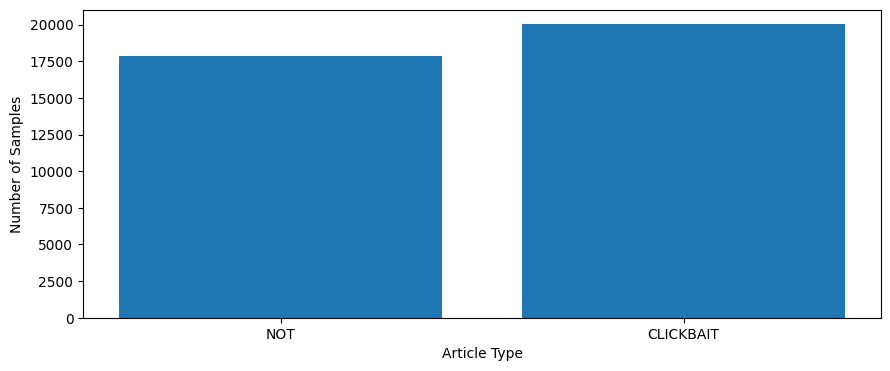

In [ ]:
#Referenced from Assignment 2, we wanted to show a bar graph of the sample distribution between the labels
import matplotlib.pyplot as plt
import numpy as np


# plot articles
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
equal_dataset, count = np.unique(raw_label_list, return_counts=True)
print(count)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = {'NOT', 'CLICKBAIT'},fontsize=10)
plt.xlabel('Article Type')
plt.tick_params(labelsize=10)
plt.ylabel('Number of Samples')
plt.show()

[17850 17850]


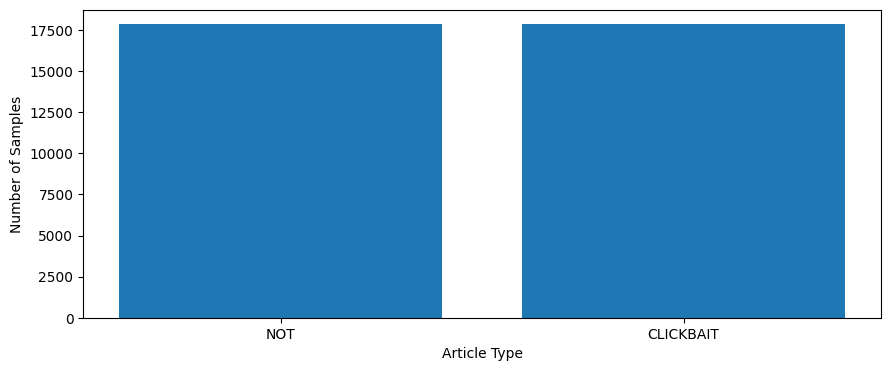

In [ ]:
# plot the reduced dataset
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
equal_dataset, count = np.unique(label_list, return_counts=True)
print(count)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = {'NOT', 'CLICKBAIT'},fontsize=10)
plt.xlabel('Article Type')
plt.tick_params(labelsize=10)
plt.ylabel('Number of Samples')
plt.show()

## Let's create the train, validation, test sets

To create our dataset, we are using a method from: https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090

We will first create a training and combined test+val dataset with and 80-20 split, and then split the test+val in half. Then we can create a new dictionary and define the train, test, and val.

In [ ]:
# Split train and and test+val set

train_testvalid = equal_dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_testvalid

DatasetDict({
    train: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 28560
    })
    test: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 7140
    })
})

In [ ]:
# Split test and val
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
test_valid

DatasetDict({
    train: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3570
    })
    test: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3570
    })
})

In [ ]:
# Combine datasets

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})
dataset

DatasetDict({
    train: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 28560
    })
    test: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3570
    })
    val: Dataset({
        features: ['text_label', 'text', 'label'],
        num_rows: 3570
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [6]:
# let's import the pretrained faster tokenizer from huggingface
# source: (https://huggingface.co/distilbert-base-uncased)

from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
# tokenize the text in batches with truncation and padding based on BERT requirements

def tokenization(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

NameError: name 'dataset' is not defined

# Setup Training Metrics (Accuracy, F1)

In [ ]:
import evaluate
import numpy as np

# we setup the training to evaluate the accuracy and f1 scores

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

# Setup Training Configurations

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# get bert model with a sequence classification head for sentiment analysis
# source: (https://huggingface.co/distilbert-base-uncased)
checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'NOT',1:'CLICKBAIT'}
label2id = {'NOT':0,'CLICKBAIT':1}
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# setup custom training arguments
# 1. store training checkpoints to 'results' output directory
# 2. fine-tune for just 1 epoch
# 3,4. use 16 as a batch size to speed things up
# 5. evaluate validation set every 500 steps (this is the default steps)
# 6. load the best model based on the lowest validation loss at the end of training
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='steps',
    load_best_model_at_end=True,
)

# setup trainer with custom metrics (accuracy, f1)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [ ]:
# let's first evaluate unfine-tuned model with test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.7074949741363525,
 'eval_model_preparation_time': 0.0087,
 'eval_accuracy': 0.30840336134453783,
 'eval_f1': 0.3856680766359791,
 'eval_runtime': 54.4353,
 'eval_samples_per_second': 65.582,
 'eval_steps_per_second': 2.057}

Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with Clickbait Dataset

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
500,0.133100,0.104088,0.008700,0.970868,0.971271
1000,0.084300,0.084063,0.008700,0.977311,0.977456
1500,0.033200,0.100239,0.008700,0.977031,0.977044
2000,0.024900,0.119757,0.008700,0.975910,0.976004
2500,0.009500,0.144609,0.008700,0.973669,0.973961
3000,0.004800,0.178690,0.008700,0.973950,0.974159
3500,0.001300,0.178661,0.008700,0.973389,0.973501
4000,0.000900,0.193196,0.008700,0.974230,0.974259


TrainOutput(global_step=4465, training_loss=0.03282067268452746, metrics={'train_runtime': 6790.498, 'train_samples_per_second': 21.029, 'train_steps_per_second': 0.658, 'total_flos': 1.89163445280768e+16, 'train_loss': 0.03282067268452746, 'epoch': 5.0})

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.10884496569633484,
 'eval_model_preparation_time': 0.0087,
 'eval_accuracy': 0.9680672268907563,
 'eval_f1': 0.9677601809954751,
 'eval_runtime': 49.5468,
 'eval_samples_per_second': 72.053,
 'eval_steps_per_second': 2.26,
 'epoch': 5.0}

In [ ]:
# to save our model, we referenced https://discuss.huggingface.co/t/how-to-save-my-model-to-use-it-later/20568/2
trainer.save_model("./my_model")

# Try out some examples!

Loading in a pre-trained model

In [14]:
#reference: https://discuss.huggingface.co/t/how-to-save-my-model-to-use-it-later/20568/6
# Make sure you run the very first block of code in the repo to load in our github files!
from transformers import BertConfig, BertModel, AutoModelForSequenceClassification
# from local folder
model = AutoModelForSequenceClassification.from_pretrained("/content/Clickbait-Detector/pretrainedModel")

In [15]:
from transformers import pipeline
import torch

# get current device with pytorch
device = torch.cuda.current_device()

# create pipeline for sentiment classifier with custom model and tokenizer
sentiment_classifier = pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

Lets try the model on a few new examples we found. Below is an article we thought was clickbait, and the model agreed with a score of 0.99!

In [19]:
# let's see how our model classifies a non-clickbait article
# this is from: https://www.cbc.ca/kidsnews/post/somebody-paid-6.2-million-for-this-duct-taped-banana-seriously
article = """
Somebody paid $6.2 million for this duct-taped banana. Seriously
"""
sentiment_classifier(article)

[{'label': 'CLICKBAIT', 'score': 0.9990646243095398}]

Here is an artile we thought was not clickbait, and the model agreed with a score of 0.78

In [18]:
# let's see how our model classifies a non-clickbait article
# this is from: https://globalnews.ca/news/10892978/vanessa-terry-justice-court-appearance/

review = """
‘We need justice’: Family of slain B.C. woman speaks out over domestic homicide case
"""
sentiment_classifier(review)

[{'label': 'NOT', 'score': 0.7886931300163269}]

Here is one tricky example. We agreed that this article would not be clickbait, but the model identified that it was and with a score of 0.97. This highlights how subjective the identification of clickbait can be.

In [20]:
# this is from: https://dailyhive.com/vancouver/id-boarding-domestic-yvr-air-canada
article = """
You won't have to show ID at the gate anymore for some flights at YVR Airport
"""
sentiment_classifier(article)

[{'label': 'CLICKBAIT', 'score': 0.974324643611908}]

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).